In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regain import utils; reload(utils);


In [ ]:
def base_results(mdl, X, y, K, K_obs, ells, search_spaces=None, **params):
    ll = mdl.set_params(**params)

    tic = time.time()
    if search_spaces is None:
        ll.fit(X, y)
    else:
        ll = use_bscv(ll, search_spaces, X, y)
    tac = time.time()

    ss = utils.structure_error(K, ll.precision_)
    MSE_precision = utils.error_norm(K, ll.precision_, upper_triangular=True)

    res = dict(
        n_dim_obs=K.shape[1], time=tac - tic, iterations=ll.n_iter_,
        MSE_precision=MSE_precision, estimator=ll, likelihood=ll.score(X, y))

    if hasattr(ll, 'latent_'):
        res['MSE_observed'] = utils.error_norm(
            K_obs, ll.precision_ - ll.latent_)
        res['MSE_latent'] = utils.error_norm(ells, ll.latent_)
        res['mean_rank_error'] = utils.error_rank(ells, ll.latent_)

    res = dict(res, **ss)
    return res

In [ ]:
import seaborn as sns
# kernel used to generate data
sns.heatmap(kernels.ExpSineSquared(periodicity=np.pi,
                                      length_scale=2)(np.arange(10)[:,None]))


In [ ]:

# setting 1
n_samples = 100
T = 10
n_dim_obs = 5

k = (n_dim_obs, T)

np.random.seed(0)

reload(datasets)
data = {(dim, T) : datasets.make_dataset(
    mode='sin', shape='smooth',
    update_theta='l2', normalize_starting_matrices=False,
    n_samples=n_samples, n_dim_lat=0, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=True, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [ ]:
data

In [ ]:
# info on the data set
K = data[(5, 10)].thetas
print ("Percentual of non-zero components at each time: {}".format(
    [(i!=0).sum() / i.size for i in K]))

print ("Percentual of total non-zero components: {}".format(
    (K != 0).sum() / (n_dim_obs ** 2 * T)))

In [ ]:
d

In [ ]:
# run_results(data[:2], dff, scores)

idx = pd.IndexSlice
for i, res in enumerate(data.values()):
    #if i > 5 or i < 2: continue
    # dim = k[0]
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    # to use it later for grid search
    data_grid = np.array(data_list).transpose(1, 2, 0)
    T = data_list.shape[0]
    print("Start with: dim=%d, T=%d (it %d)" % (data_list.shape[-1], T, i))

In [ ]:
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalGraphicalModel
mdl = TemporalGraphicalModel(distribution='gaussian',
        alpha=0.5, psi='laplacian', assume_centered=0, rtol=1e-5, tol=1e-5,
        max_iter=1000, rho=1. / np.sqrt(data_list.shape[1]),
        update_rho_options=dict(mu=5), kernel=partial(
            kernels.ExpSineSquared, periodicity=np.pi), ker_param=2)

X = np.vstack(data_list)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(data_list)]).flatten().astype(int)
base_results(mdl, X, y, K, K_obs, ells, search_spaces=None)

# ISING

In [ ]:
from regain._datasets.ising import ising_theta_generator

thetas = ising_theta_generator(p=5, n=100, T=10, mode='l1', time_on_axis='first',
          change=4, responses=[-1,1])


In [ ]:
from regain.generalized_linear_model.sampling import ising_sampler

np.array([ising_sampler(t, np.zeros(5), n=100,
                        responses=[-1,1]) for t in thetas])

In [116]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=5,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [142]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
ising_mdl = Ising_GLM_GM(alpha=0.25, mode='symmetric_fbs', verbose=0)
ising_mdl.fit(samples[3])

Ising_GLM_GM(alpha=0.25, compute_objective=True, max_iter=100,
       mode='symmetric_fbs', reconstruction='union', return_history=True,
       return_n_iter=False, rho=1, rtol=0.0001, tol=0.0001, verbose=0)

In [143]:
thetas[0].shape

(5, 5)

In [144]:
utils.structure_error(np.array(thetas[3]), ising_mdl.precision_, no_diagonal=True)

{'tp': 12,
 'tn': 8,
 'fp': 0,
 'fn': 0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'accuracy': 0.8,
 'false_omission_rate': 0.0,
 'fdr': 0.0,
 'npv': 1.0,
 'prevalence': 0.48,
 'miss_rate': 0.0,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 0.0,
 'dor': 0,
 'balanced_accuracy': 1.0,
 'average_precision': 1.0}

In [198]:
import regain.covariance.time_graphical_lasso_; reload(regain.covariance.time_graphical_lasso_)
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalGraphicalModel

kernel = np.ones((10,10))*1e-5
np.fill_diagonal(kernel, 1)
mdl = TemporalGraphicalModel(distribution='ising',
        alpha=10, psi='l1', assume_centered=0, rtol=1e-5, tol=1e-5,
        max_iter=300, rho=1.,
        update_rho_options=dict(mu=5), kernel=kernel, init='zeros', verbose=1)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [199]:
mdl.fit(X, y)

ising
obj: 3922.8412, rnorm: 3.7556, snorm: 11.2665,eps_pri: 0.0006, eps_dual: 0.0005
ising
obj: 4070.0058, rnorm: 5.0667, snorm: 4.1085,eps_pri: 0.0007, eps_dual: 0.0006
ising
obj: 4072.8473, rnorm: 5.0932, snorm: 0.0846,eps_pri: 0.0007, eps_dual: 0.0006
ising
obj: 4073.0461, rnorm: 5.0950, snorm: 0.0119,eps_pri: 0.0007, eps_dual: 0.0007
ising
obj: 4073.2397, rnorm: 5.0968, snorm: 0.0233,eps_pri: 0.0007, eps_dual: 0.0009
ising
obj: 3875.6035, rnorm: 4.7799, snorm: 6.2749,eps_pri: 0.0007, eps_dual: 0.0013
ising
obj: 2457.1373, rnorm: 3.3125, snorm: 23.2576,eps_pri: 0.0007, eps_dual: 0.0015
ising
obj: 1348.1241, rnorm: 2.2844, snorm: 8.8624,eps_pri: 0.0007, eps_dual: 0.0016
ising
obj: 1032.7169, rnorm: 1.8111, snorm: 4.9126,eps_pri: 0.0007, eps_dual: 0.0016
ising
obj: 944.1441, rnorm: 1.5929, snorm: 2.9487,eps_pri: 0.0007, eps_dual: 0.0017
ising
obj: 841.9916, rnorm: 1.3321, snorm: 3.1853,eps_pri: 0.0007, eps_dual: 0.0017
ising
obj: 749.9440, rnorm: 1.0930, snorm: 2.5392,eps_pri: 0.0007

ising
obj: 482.5937, rnorm: 0.0178, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 481.9713, rnorm: 0.0178, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 481.3497, rnorm: 0.0177, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 480.7287, rnorm: 0.0177, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 480.1084, rnorm: 0.0176, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 479.4888, rnorm: 0.0176, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 478.8699, rnorm: 0.0175, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 478.2517, rnorm: 0.0175, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 477.6343, rnorm: 0.0174, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 477.0174, rnorm: 0.0174, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 476.4013, rnorm: 0.0173, snorm: 0.0106,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 475.7859, rnorm: 0.0173, snorm: 0.0105,eps_pri: 0.0007, eps_dual:

ising
obj: 424.7576, rnorm: 0.0133, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 424.1985, rnorm: 0.0133, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 423.6400, rnorm: 0.0133, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 423.0821, rnorm: 0.0132, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 422.5248, rnorm: 0.0132, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 421.9681, rnorm: 0.0131, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 421.4120, rnorm: 0.0131, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 420.8564, rnorm: 0.0131, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 420.3015, rnorm: 0.0130, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 419.7471, rnorm: 0.0130, snorm: 0.0098,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 419.1933, rnorm: 0.0129, snorm: 0.0097,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 418.6402, rnorm: 0.0129, snorm: 0.0097,eps_pri: 0.0007, eps_dual:

ising
obj: 372.7352, rnorm: 0.0107, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 372.2309, rnorm: 0.0107, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 371.7271, rnorm: 0.0106, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 371.2239, rnorm: 0.0106, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 370.7211, rnorm: 0.0106, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019
ising
obj: 370.2189, rnorm: 0.0106, snorm: 0.0091,eps_pri: 0.0007, eps_dual: 0.0019


/Users/veronica/Desktop/git_repos/regain/regain/generalized_linear_model/time.py:299: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


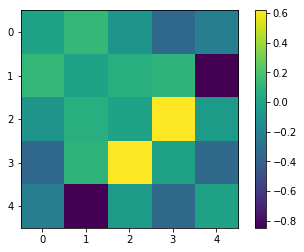

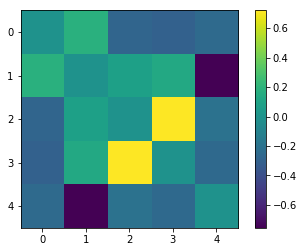

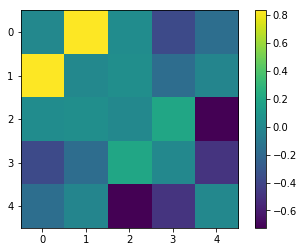

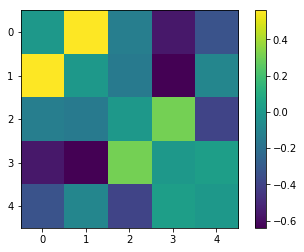

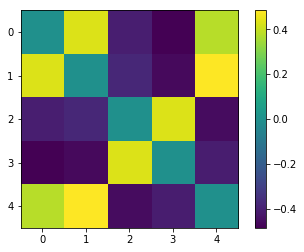

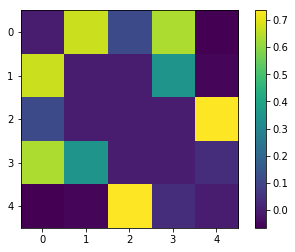

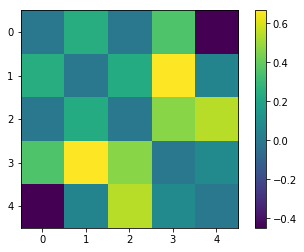

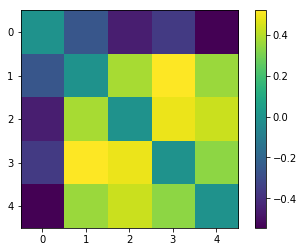

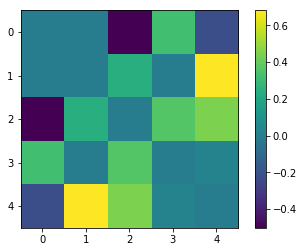

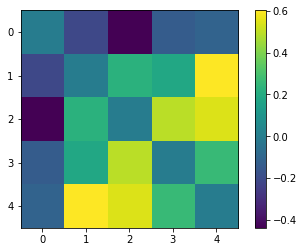

In [200]:
for p in mdl.precision_:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

In [201]:
ss = utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)
MSE_precision = utils.error_norm(np.array(thetas), mdl.precision_, upper_triangular=True)

In [202]:
ss

{'tp': 100,
 'tn': 8,
 'fp': 92,
 'fn': 0,
 'precision': 0.5208333333333334,
 'recall': 1.0,
 'f1': 0.684931506849315,
 'accuracy': 0.432,
 'false_omission_rate': 0.0,
 'fdr': 0.4791666666666667,
 'npv': 1.0,
 'prevalence': 0.4,
 'miss_rate': 0.0,
 'fall_out': 0.92,
 'specificity': 0.08,
 'plr': 1.0869565217391304,
 'nlr': 0.0,
 'dor': 0,
 'balanced_accuracy': 0.54,
 'average_precision': 0.9803261239202882}

In [ ]:
K.shape

In [ ]:
X.shape

In [ ]:
samples[0].shape

In [ ]:
len(samples)